In [2]:
# Standard libraries
import os
import math
import time

# Data manipulation and analysis
import numpy as np
import pandas as pd


#Data Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from datetime import datetime,date,timedelta


# Machine Learning - Scikit-learn

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, ParameterGrid, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import  MinMaxScaler, StandardScaler


# Deep Learning - TensorFlow and Keras
import keras
import random
import tensorflow as tf
import keras.utils
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError


In [3]:
# Readin the data set kepping date as index
df=pd.read_csv('weighted_sum.csv')

# Make the 'date' column as index of the DataFrame
df.index = df["date"].values

df.index = pd.to_datetime(df.index)

df.drop(columns='date', inplace=True)

# Reindexing DataFrame with pd.date_range, ensure df spans a specified period, filling in any gaps with NaN values.
idx = pd.date_range('2019-10-24', '2023-12-06')

df = df.reindex(idx)

# filter out the specified data range contaning zero
df=df.drop(df.loc['2023-05-12':'2023-07-27'].index)

# Filter out the initial date range considering machine unstability
df=df.drop(df.loc['2019-10-24':'2020-01-31'].index)


rows_to_fill = np.where(df["weighted_sum"].isna())

for row in rows_to_fill:

    df.iloc[row] = df.iloc[row + 7]

# Replace negative values with zero in 'weighted_sum'
df['weighted_sum'] = df['weighted_sum'].clip(lower=0)

# replace 7 irregular data points with 8th highest value.
df[df['weighted_sum']>570]=570

print(df)

            weighted_sum
2020-02-01    239.210369
2020-02-02     28.280318
2020-02-03    199.366981
2020-02-04    423.067131
2020-02-05    409.692107
...                  ...
2023-12-02    114.049422
2023-12-03      0.000000
2023-12-04    226.893157
2023-12-05    390.659238
2023-12-06    425.322937

[1328 rows x 1 columns]


In [6]:
# transformation of data in supervised learning
def ts_to_supervised(data, time_step=1):
    df = pd.DataFrame(data)
    cols = [df.shift(i) for i in range(1, time_step + 1)]
    cols.append(df)
    data = pd.concat(cols, axis=1)
    data.fillna(0, inplace=True)
   
    # Rename columns to indicate time steps
    col_names = [f't-{i}' for i in range(1, time_step + 1)] + ['t']
    data.columns = col_names  # Assign column names
    return data.values[:, :-1], data.values[:, -1] # selects all columns except the last one, selects only the last column

# Transform to supervised learning
# train data
X_train, y_train= ts_to_supervised(train_data, time_step=7)

# test data
X_test, y_test= ts_to_supervised(test_data, time_step=7)

# Combine X and y into a single DataFrame 
supervised_df = pd.DataFrame(X_train, columns=[f't-{i}' for i in range(7, 0, -1)])
supervised_df['t'] = y_train

 # Print the first 20 rows
print(supervised_df.head(15))

           t-7         t-6         t-5         t-4         t-3         t-2  \
0     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
1   239.210369    0.000000    0.000000    0.000000    0.000000    0.000000   
2    28.280318  239.210369    0.000000    0.000000    0.000000    0.000000   
3   199.366981   28.280318  239.210369    0.000000    0.000000    0.000000   
4   423.067131  199.366981   28.280318  239.210369    0.000000    0.000000   
5   409.692107  423.067131  199.366981   28.280318  239.210369    0.000000   
6   418.642235  409.692107  423.067131  199.366981   28.280318  239.210369   
7   437.622738  418.642235  409.692107  423.067131  199.366981   28.280318   
8   267.654169  437.622738  418.642235  409.692107  423.067131  199.366981   
9    25.190742  267.654169  437.622738  418.642235  409.692107  423.067131   
10  453.688387   25.190742  267.654169  437.622738  418.642235  409.692107   
11  452.785706  453.688387   25.190742  267.654169  437.622738  

In [4]:
# function for Transform Data to Supervised Learning Format
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        dataX.append(dataset.iloc[i:(i + time_step), 0])  # Corrected indexing for Pandas
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


In [24]:
keras.utils.set_random_seed(8332)
# Set parameters for the model
num_layers = 2
num_neurons = 50
dropout_rate = 0.1
time_step = 7
num_epochs = 50 
learning_rate = 0.001 
batch_size = 32  

# Define the train-test split parameters
initial_train_size = int(0.7 * len(df))  # Start with 70% training data
n_splits = (len(df) - initial_train_size)  # Remaining data for testing
test_size = 1  # Fixed test set size for each fold



# Initialize lists to hold RMSE for each fold across all splits
mse_test_values_all = []
mse_train_values_all = []

# List to hold all predictions
predictions_all_test = []
predictions_all_train =[]

X, y = create_dataset(df, time_step=time_step)

initial_train_size = int(len(X) * 0.7)
n_splits = len(X) - initial_train_size
test_size = 1 


# Iterate through the rolling cross-validation process for all folds
for start in range(0, n_splits, 99):  # Adjust to cover all folds in batches of 99
    end = start + 99  # Each iteration covers 99 data points
    if end > n_splits: 
        end = n_splits # Adjust the final batch to include all remaining split  

    for i in range(start, end, test_size):
       
        # Define the end points for the current fold
        train_end = initial_train_size + i
        test_end = min(train_end + test_size, len(df))  # Ensure not to exceed data length
       

        # Define the current training and test data for this split
        #train_data = df.iloc[:train_end]
        #test_data = df.iloc[train_end:test_end]

        X_train = X[:train_end]
        X_test = X[train_end:test_end]
        y_train = y[:train_end]
        y_test = y[train_end:test_end]
        #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
  
        # Transform to supervised learning
        #X_train, y_train = create_dataset(train_data, time_step=time_step)
        #X_test, y_test = create_dataset(test_data, time_step=time_step)

        # Reshape input to be [samples, time steps, features] for LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
       
        # Build the LSTM model
        model = Sequential()
        model.add(keras.Input(shape=(time_step, 1)))

        for _ in range(num_layers - 1):
            model.add(LSTM(num_neurons, activation='relu', return_sequences=True))

        model.add(LSTM(num_neurons, dropout=dropout_rate, activation='relu'))
        model.add(Dense(1))

        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['root_mean_squared_error'])

        t1 = time.time()
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=False)
        t2 = time.time()
        print()
        print(f"Training time for fold {i // test_size + 1}: {t2 - t1:.2f} seconds")

        # Make predictions on the train and test data
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    
        # Calculate RMSE
        train_mse = mean_squared_error(y_train, y_pred_train)
        test_mse = mean_squared_error(y_test, y_pred_test)
        
        
        # Store RMSE for this fold
        mse_test_values_all.append(test_mse)
        mse_train_values_all.append(train_mse)

        # Store predictions for the current split
        predictions_all_test.append(y_pred_test)
        predictions_all_train.append(y_pred_train)

        print(f'\nFold {i // test_size + 1} Test MSE: {test_mse:.4f}')
        print(f'\nFold {i // test_size + 1} Train MSE: {train_mse:.4f}')
        print(f'\nFold {i // test_size + 1} Prediction : {y_pred_test}')
        
        #plt.plot(y_pred_train)
        #plt.show()
        #plt.clf()
        #plt.plot(y_pred_test)
        #plt.show()
        #plt.clf()

# After all folds, calculate the average MSE for both train and test
average_mse_test_all = np.mean(mse_test_values_all)
average_mse_train_all = np.mean(mse_train_values_all)

# Calculate RMSE from the average MSE
rmse_test = np.sqrt(average_mse_test_all)
rmse_train = np.sqrt(average_mse_train_all)

# Print the average RMSE across all folds
print(f"\nAverage Train RMSE across all folds: {rmse_train:.4f}")
print(f"Average Test RMSE across all folds: {rmse_test:.4f}")



X_train shape: (923, 7, 1), X_test shape: (1, 7, 1)

Training time for fold 1: 5.35 seconds
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Fold 1 Test MSE: 31108.6304

Fold 1 Train MSE: 7079.1642

Fold 1 Prediction : [[255.67706]]
X_train shape: (924, 7, 1), X_test shape: (1, 7, 1)

Training time for fold 2: 5.23 seconds
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Fold 2 Test MSE: 1644.1809

Fold 2 Train MSE: 6391.8135

Fold 2 Prediction : [[174.78847]]
X_train shape: (925, 7, 1), X_test shape: (1, 7, 1)

Training time for fold 3: 5.27 seconds
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Fold 3 Test MSE: 2222.3712

Fold 3 Train MSE: 7293.6045

Fold 3 Prediction : [[47.142033]]
X_train shape: (926, 7, 1), X_test shape: (1, 7, 1)

Training time for fold 4: 5.30 seconds
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Fold 4 Test MSE: 5367.2438

Fold 4 Train MSE: 

In [26]:
# Now, split the initial training data into 70% training and 30% validation
train_size = int(0.7 * len(df))
train_data = df.iloc[:train_size]  # Use iloc to slice without losing the index
test_data = df.iloc[train_size:]    # Use iloc to slice without losing the index

# Print the shapes and check the indices
print(train_data.shape, test_data.shape)

# Display the train and test data with the original date index
print(train_data.head())
print(test_data.head())

(929, 1) (399, 1)
            weighted_sum
2020-02-01    239.210369
2020-02-02     28.280318
2020-02-03    199.366981
2020-02-04    423.067131
2020-02-05    409.692107
            weighted_sum
2022-08-18    193.901423
2022-08-19    432.053452
2022-08-20    134.239967
2022-08-21      0.000000
2022-08-22    293.099946


#### Convert predictions_all (which is a list of arrays) into a flat array

In [29]:
# Convert predictions_all (which is a list of arrays) into a flat array
predictions_test_flat = np.concatenate(predictions_all_test)
predictions_test_flat= predictions_test_flat.clip(min=0)


predictions_train_flat = np.concatenate(predictions_all_train)
predictions_train_flat= predictions_train_flat.clip(min=0)

test_data.index = pd.to_datetime(test_data.index)

# Find the index of the highest value in predictions_all_flat
highest_value_index = np.argmax(predictions_test_flat)

# Use the index to get the highest value and the corresponding prediction
highest_value = predictions_test_flat[highest_value_index]

# Print the result
print(f"Highest value: {highest_value} at index: {highest_value_index}")


Highest value: [472.36572] at index: 55


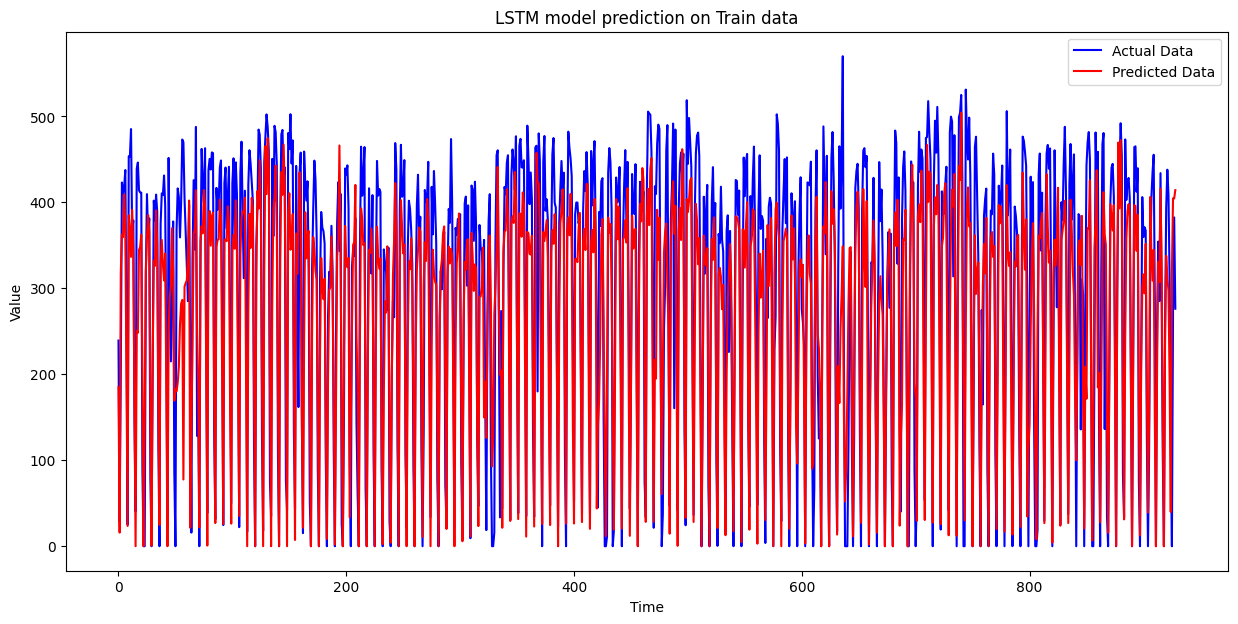

In [31]:
# Plot the actual train data
plt.figure(figsize=(15,7))
plt.plot(range(len(train_data)), train_data, label='Actual Data', color='blue')

# Plot the predictions (aligned with the same indices as test_data)
plt.plot(range(len(train_data)), predictions_train_flat[0:929], label='Predicted Data', color='red')

# Add title and labels
plt.title('LSTM model prediction on Train data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.savefig('lstm prediction_train')
# Add legend
plt.legend()

# Show the plot
plt.show()

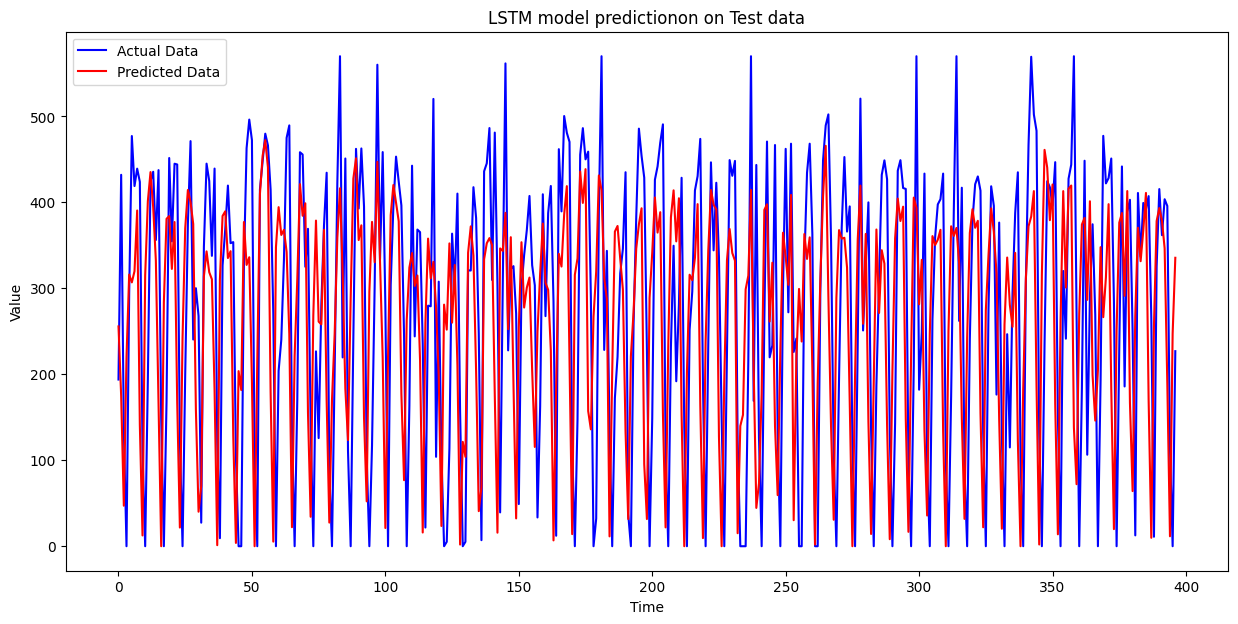

In [33]:
# Plot the actual train data
plt.figure(figsize=(15,7))
plt.plot(range(len(test_data[:397])), test_data[:397], label='Actual Data', color='blue')

# Plot the predictions (aligned with the same indices as test_data)
plt.plot(range(len(test_data[:397])), predictions_test_flat[0:397], label='Predicted Data', color='red')

# Add title and labels
plt.title('LSTM model predictionon on Test data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.savefig('lstm prediction_test')
# Add legend
plt.legend()

# Show the plot
plt.show()

DatetimeIndex(['2022-08-18', '2022-08-19', '2022-08-20', '2022-08-21',
               '2022-08-22', '2022-08-23', '2022-08-24', '2022-08-25',
               '2022-08-26', '2022-08-27',
               ...
               '2023-11-27', '2023-11-28', '2023-11-29', '2023-11-30',
               '2023-12-01', '2023-12-02', '2023-12-03', '2023-12-04',
               '2023-12-05', '2023-12-06'],
              dtype='datetime64[ns]', length=399, freq=None)


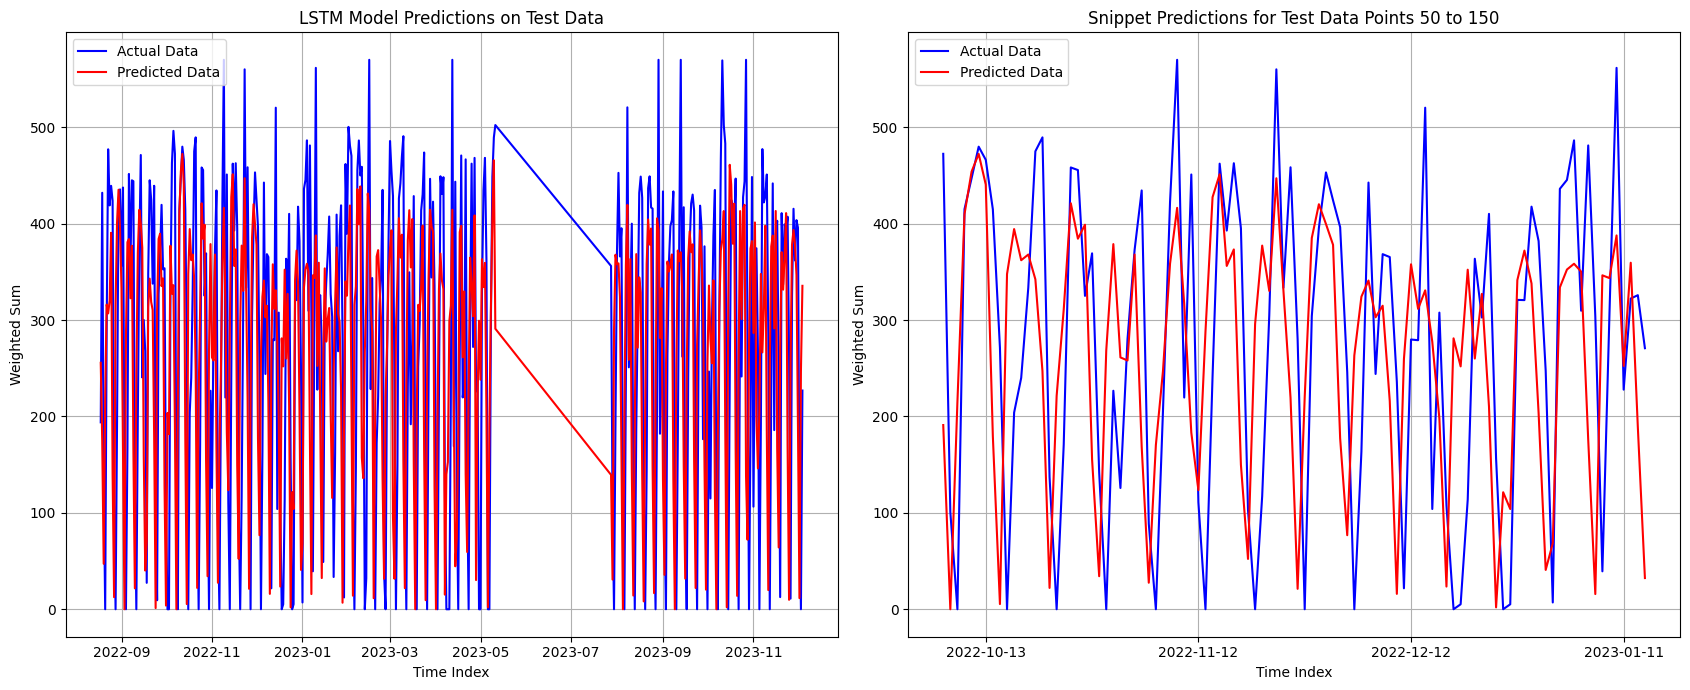

In [35]:
# Convert the index of test_data to DatetimeIndex
test_data.index = pd.to_datetime(test_data.index)
print(test_data.index)

# Create a figure with specific size
fig = plt.figure(figsize=(17, 7))

# Create a gridspec layout: 1 row, 2 columns
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 2])  # Adjust the width ratios as needed

# Plot LSTM Model Predictions for test data
ax1 = fig.add_subplot(gs[0])
ax1.plot(test_data.index[:397], test_data[:397], label='Actual Data', color='blue')
ax1.plot(test_data.index[:397], predictions_test_flat[:397], label='Predicted Data', color='red')
ax1.legend()
ax1.set_xlabel('Time Index')
ax1.set_ylabel('Weighted Sum')
ax1.set_title('LSTM Model Predictions on Test Data')
ax1.grid(True)  # Adding grid lines

# Plot LSTM Model Predictions for train data
ax2 = fig.add_subplot(gs[1])
ax2.plot(test_data.index[50:150], test_data.values[50:150], label='Actual Data', color='blue')
ax2.plot(test_data.index[50:150], predictions_test_flat[50:150], label='Predicted Data', color='red')
ax2.legend()
ax2.set_xlabel('Time Index')
ax2.set_ylabel('Weighted Sum')

ax2.set_title('Snippet Predictions for Test Data Points 50 to 150')

# Set x-axis ticks to every 7 days
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax2.grid(True)  # Adding grid lines

# Improve the layout
plt.tight_layout()

# Save the figure as a single image
plt.savefig('LSTM_test_Predictions.png')

# Display the plots
plt.show()

DatetimeIndex(['2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04',
               '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08',
               '2020-02-09', '2020-02-10',
               ...
               '2022-08-08', '2022-08-09', '2022-08-10', '2022-08-11',
               '2022-08-12', '2022-08-13', '2022-08-14', '2022-08-15',
               '2022-08-16', '2022-08-17'],
              dtype='datetime64[ns]', length=929, freq=None)


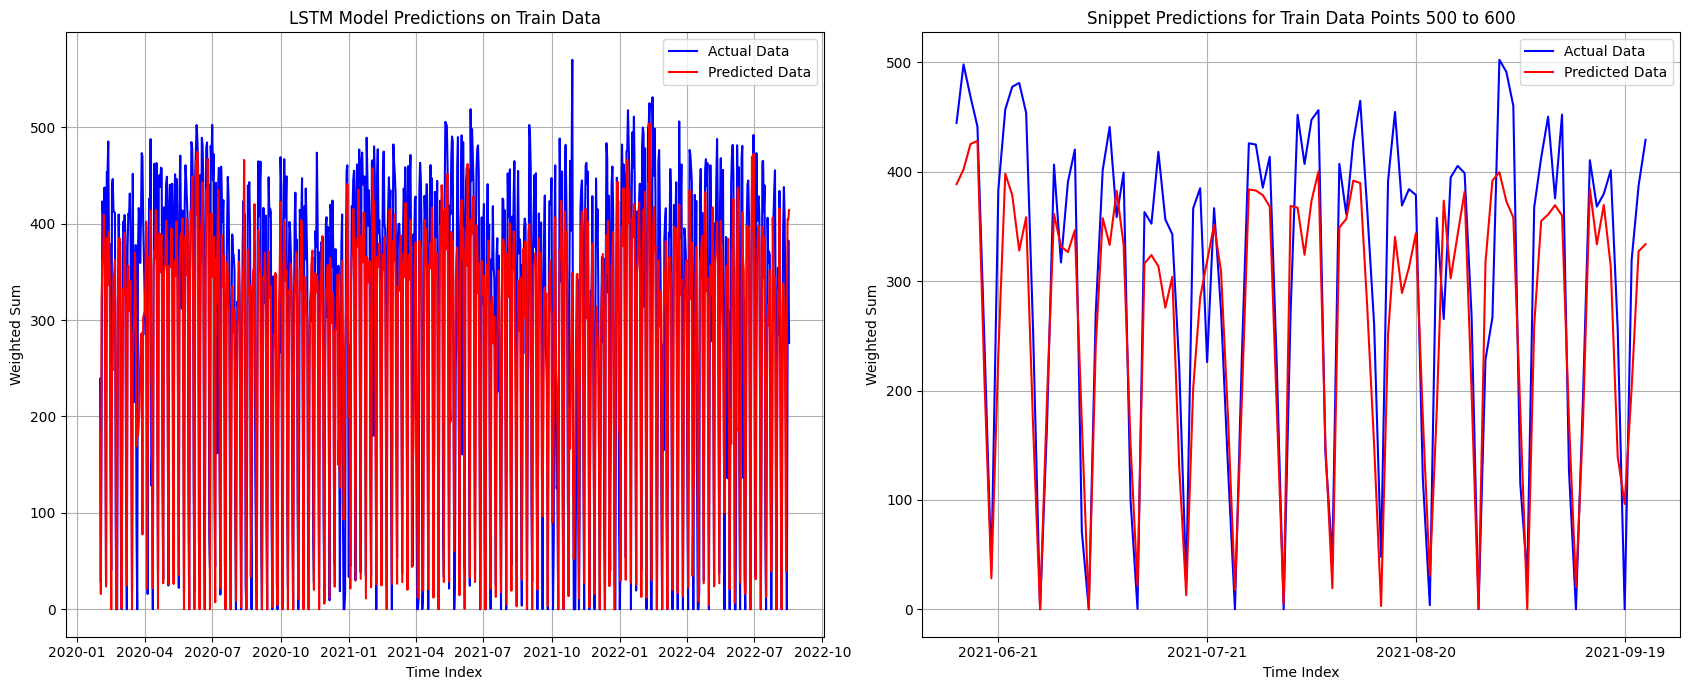

In [37]:
# Convert the index of test_data to DatetimeIndex
train_data.index = pd.to_datetime(train_data.index)
print(train_data.index)

# Create a figure with specific size
fig = plt.figure(figsize=(17, 7))

# Create a gridspec layout: 1 row, 2 columns
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 2])  # Adjust the width ratios as needed

# Plot LSTM Model Predictions for test data
ax1 = fig.add_subplot(gs[0])
ax1.plot(train_data.index, train_data, label='Actual Data', color='blue')
ax1.plot(train_data.index, predictions_train_flat[0:929], label='Predicted Data', color='red')
ax1.legend()
ax1.set_xlabel('Time Index')
ax1.set_ylabel('Weighted Sum')
ax1.set_title('LSTM Model Predictions on Train Data')
ax1.grid(True)  # Adding grid lines

# Plot LSTM Model Predictions for train data
ax2 = fig.add_subplot(gs[1])
ax2.plot(train_data.index[500:600], train_data.values[500:600], label='Actual Data', color='blue')
ax2.plot(train_data.index[500:600], predictions_train_flat[500:600], label='Predicted Data', color='red')
ax2.legend()
ax2.set_xlabel('Time Index')
ax2.set_ylabel('Weighted Sum')
ax2.set_title('Snippet Predictions for Train Data Points 500 to 600')

# Set x-axis ticks to every 7 days
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax2.grid(True)  # Adding grid lines

# Improve the layout
plt.tight_layout()

# Save the figure as a single image
plt.savefig('LSTM_train_Predictions.png')

# Display the plots
plt.show()

### SARIMA and LSTM model Predictions once on Test Data Points 300 to 380 

In [68]:
# Standard libraries
import os
import math
import time

# Data manipulation and analysis
import numpy as np
import pandas as pd

#Data Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

# datetime index
from datetime import datetime,date,timedelta

# Machine Learning - Scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, ParameterGrid, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import  MinMaxScaler, StandardScaler

# Satistical analysis- SARIMAX (statsmodels)
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product 

import warnings
warnings.filterwarnings('ignore')

In [70]:


# Define the train-test split parameters
initial_train_size = int(0.7 * len(df))  # Start with 70% training data
n_splits = len(df) - initial_train_size  # Remaining data for testing
test_size = 1 # Fixed test set size for each fold

n_folds = n_splits // test_size
print(f'\nNumber of folds: {n_folds}')
print(f"\nInitial train size: {initial_train_size}, Number of splits: {n_splits}")


# Initialize list to store RMSE values for each fold
mse_test_values = []
mse_train_values = []

# Store predictions to compare later
predictions_test_alls = []
predictions_train_alls = []

# Iterate through the rolling cross-validation process
for i in range(0, n_splits, test_size):
    
    # Define the end points for the current fold
    train_end = initial_train_size + i
    test_end = min(train_end + test_size, len(df))  # Ensure not to exceed data length

    # Define the current training and test data for this split
    train_data = df.iloc[:train_end]
    test_data = df.iloc[train_end:test_end]

    # Fit the SARIMAX model
    model = SARIMAX(train_data, 
                    order=(1, 1, 1), 
                    seasonal_order=(1, 0, 1, 7), 
                    enforce_stationarity=False, 
                    enforce_invertibility=False) 

    model_fit = model.fit(disp=False)

    # Make predictions on the test data
    predictions_test = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    predictions_train = model_fit.predict(start=0, end=len(train_data) - 1)
    
    predictions_test_alls.append(predictions_test)
    predictions_train_alls.append(predictions_train)

    # Calculate RMSE on the test data
    mse_test = mean_squared_error(test_data, predictions_test)
    mse_train = mean_squared_error(train_data, predictions_train)

    mse_test_values.append(mse_test)
    mse_train_values.append(mse_train)
       
    print(f'\nFold {i // test_size + 1} Test MSE: {mse_test:.4f}')
    print(f'\nFold {i // test_size + 1} Train MSE: {mse_train:.4f}')

# After all folds, calculate the average MSE for both train and test
average_mse_test_all = np.mean(mse_test_values)
average_mse_train_all = np.mean(mse_train_values)

# Calculate RMSE from the average MSE
rmse_test = np.sqrt(average_mse_test_all)
rmse_train = np.sqrt(average_mse_train_all)

print(f"Average Test RMSE across all folds: {rmse_test:.4f}")
print(f"Average Train RMSE across all folds: {rmse_train:.4f}")


Number of folds: 399

Initial train size: 929, Number of splits: 399

Fold 1 Test MSE: 21771.3801

Fold 1 Train MSE: 6516.2252

Fold 2 Test MSE: 15772.8854

Fold 2 Train MSE: 6532.7971

Fold 3 Test MSE: 5748.4145

Fold 3 Train MSE: 9511.8440

Fold 4 Test MSE: 290.4654

Fold 4 Train MSE: 6796.5956

Fold 5 Test MSE: 866.8023

Fold 5 Train MSE: 6529.8332

Fold 6 Test MSE: 7118.8824

Fold 6 Train MSE: 6523.7753

Fold 7 Test MSE: 3.4341

Fold 7 Train MSE: 6524.5232

Fold 8 Test MSE: 3388.8643

Fold 8 Train MSE: 6517.6324

Fold 9 Test MSE: 986.5022

Fold 9 Train MSE: 6514.3866

Fold 10 Test MSE: 3736.3917

Fold 10 Train MSE: 6508.5798

Fold 11 Test MSE: 445.5735

Fold 11 Train MSE: 6508.2130

Fold 12 Test MSE: 6855.7700

Fold 12 Train MSE: 6519.1571

Fold 13 Test MSE: 11106.9747

Fold 13 Train MSE: 9518.8604

Fold 14 Test MSE: 1104.0282

Fold 14 Train MSE: 6494.6794

Fold 15 Test MSE: 1094.0882

Fold 15 Train MSE: 6489.1214

Fold 16 Test MSE: 4868.2081

Fold 16 Train MSE: 6483.2534

Fold 17

In [72]:
# Now, split the initial training data into 70% training and 30% validation
train_size = int(0.7 * len(df))
train_data = df.iloc[:train_size]  # Use iloc to slice without losing the index
test_data = df.iloc[train_size:]    # Use iloc to slice without losing the index

# Print the shapes and check the indices
print(train_data.shape, test_data.shape)

# Display the train and test data with the original date index
print(train_data.head())
print(test_data.head())

predictions_train_flats = np.concatenate(predictions_train_alls)
predictions_test_flats = np.concatenate(predictions_test_alls)

(929, 1) (399, 1)
            weighted_sum
2020-02-01    239.210369
2020-02-02     28.280318
2020-02-03    199.366981
2020-02-04    423.067131
2020-02-05    409.692107
            weighted_sum
2022-08-18    193.901423
2022-08-19    432.053452
2022-08-20    134.239967
2022-08-21      0.000000
2022-08-22    293.099946


DatetimeIndex(['2022-08-18', '2022-08-19', '2022-08-20', '2022-08-21',
               '2022-08-22', '2022-08-23', '2022-08-24', '2022-08-25',
               '2022-08-26', '2022-08-27',
               ...
               '2023-11-27', '2023-11-28', '2023-11-29', '2023-11-30',
               '2023-12-01', '2023-12-02', '2023-12-03', '2023-12-04',
               '2023-12-05', '2023-12-06'],
              dtype='datetime64[ns]', length=399, freq=None)


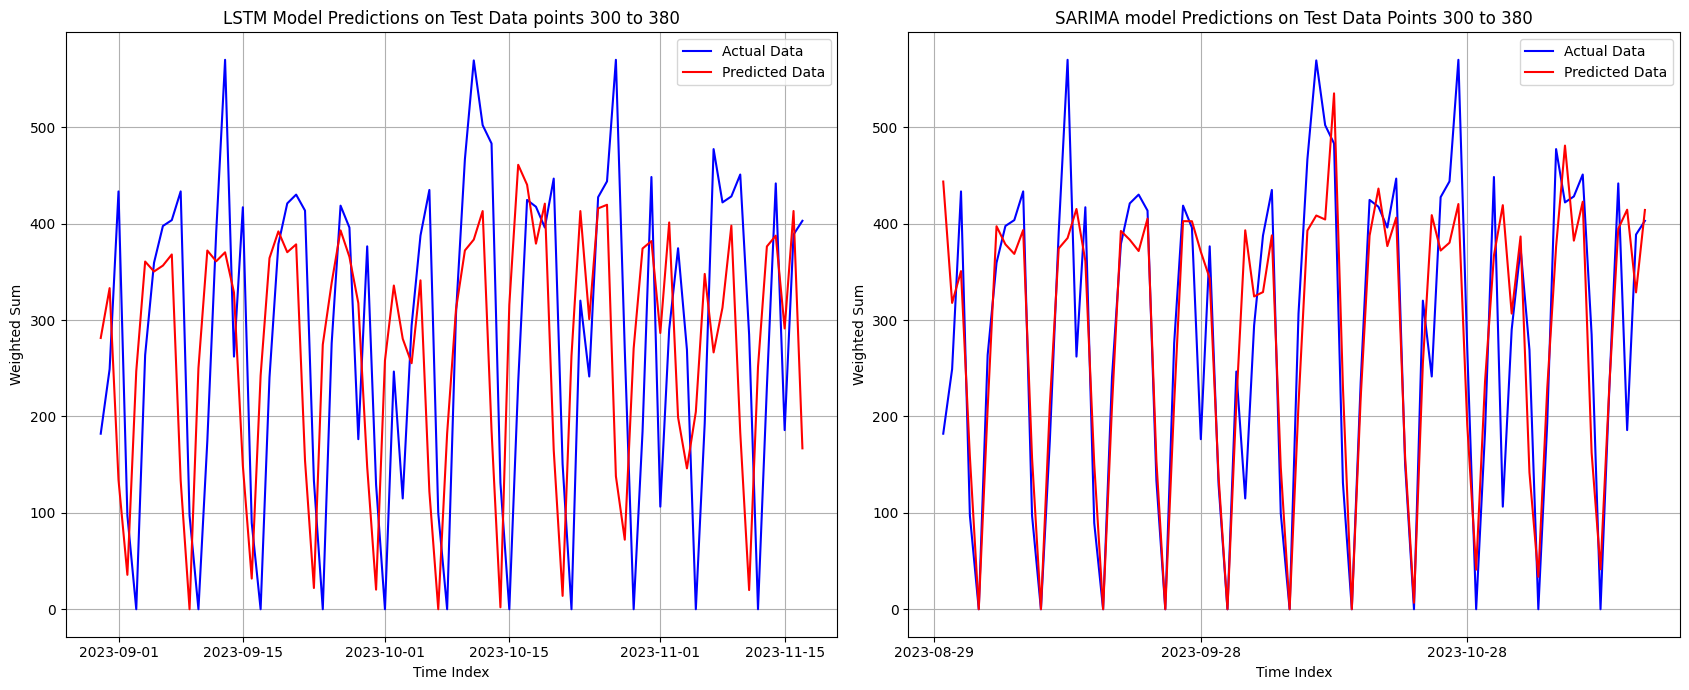

In [76]:
# Convert the index of test_data to DatetimeIndex
test_data.index = pd.to_datetime(test_data.index)
print(test_data.index)

predictions_test_flat = np.concatenate(predictions_all_test)
predictions_test_flat= predictions_test_flat.clip(min=0)
predictions_test_flats = np.concatenate(predictions_test_alls)
predictions_test_flats= predictions_test_flats.clip(min=0)
# Create a figure with specific size
fig = plt.figure(figsize=(17, 7))

# Create a gridspec layout: 1 row, 2 columns
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 2])  # Adjust the width ratios as needed

# Plot LSTM Model Predictions for test data
ax1 = fig.add_subplot(gs[0])
ax1.plot(test_data.index[300:380], test_data[300:380], label='Actual Data', color='blue')
ax1.plot(test_data.index[300:380], predictions_test_flat[300:380], label='Predicted Data', color='red')
ax1.legend()
ax1.set_xlabel('Time Index')
ax1.set_ylabel('Weighted Sum')
ax1.set_title('LSTM Model Predictions on Test Data points 300 to 380')
ax1.grid(True)  # Adding grid lines

# Plot LSTM Model Predictions for train data
ax2 = fig.add_subplot(gs[1])
ax2.plot(test_data.index[300:380], test_data.values[300:380], label='Actual Data', color='blue')
ax2.plot(test_data.index[300:380], predictions_test_flats[300:380], label='Predicted Data', color='red')
ax2.legend()
ax2.set_xlabel('Time Index')
ax2.set_ylabel('Weighted Sum')
ax2.set_title('SARIMA model Predictions on Test Data Points 300 to 380')

# Set x-axis ticks to every 7 days
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax2.grid(True)  # Adding grid lines

# Improve the layout
plt.tight_layout()

# Save the figure as a single image
plt.savefig('comparison_Predictions.png')

# Display the plots
plt.show()